In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import secrets
import contractions
import re
import seaborn as sns
import matplotlib.pyplot as plt
import lyricsgenius
from datetime import datetime
from collections import Counter
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
from spacy.tokens import Doc
import importlib

In [2]:
genius = lyricsgenius.Genius(secrets.GENIUS_ACCESS_TOKEN)
nlp = spacy.load("en_core_web_sm")

In [3]:
def remove_tokens(doc, index_to_del, list_attr=[LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP]):
    # https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8
    """
    Remove tokens from a Spacy *Doc* object without losing 
    associated information (PartOfSpeech, Dependance, Lemma, extensions, ...)
    
    Parameters
    ----------
    doc : spacy.tokens.doc.Doc
        spacy representation of the text
    index_to_del : list of integer 
         positions of each token you want to delete from the document
    list_attr : list, optional
        Contains the Spacy attributes you want to keep (the default is 
        [LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP])
    Returns
    -------
    spacy.tokens.doc.Doc
        Filtered version of doc
    """
    
    np_array = doc.to_array(list_attr) # Array representation of Doc
    
    # Creating a mask: boolean array of the indexes to delete
    mask_to_del = np.ones(len(np_array), np.bool)
    mask_to_del[index_to_del] = 0
    
    np_array_2 = np_array[mask_to_del]
    doc2 = Doc(doc.vocab, words=[t.text for t in doc if t.i not in index_to_del])
    doc2.from_array(list_attr, np_array_2)
    
    ### Modification made by @yarongon https://gist.github.com/Jacobe2169/5086c7c4f6c56e9d3c7cfb1eb0010fe8#gistcomment-2941380
    # Handling user extensions
    #  The `doc.user_data` dictionary is holding the data backing user-defined attributes.
    #  The data is based on characters offset, so a conversion is needed from the
    #  old Doc to the new one.
    #  More info here: https://github.com/explosion/spaCy/issues/2532
    arr = np.arange(len(doc))
    new_index_to_old = arr[mask_to_del]
    doc_offset_2_token = {tok.idx : tok.i  for tok in doc}  # needed for the user data
    doc2_token_2_offset = {tok.i : tok.idx  for tok in doc2}  # needed for the user data
    new_user_data = {}
    for ((prefix, ext_name, offset, x), val) in doc.user_data.items():
        old_token_index = doc_offset_2_token[offset]
        new_token_index = np.where(new_index_to_old == old_token_index)[0]
        if new_token_index.size == 0:  # Case this index was deleted
            continue
        new_char_index = doc2_token_2_offset[new_token_index[0]]
        new_user_data[(prefix, ext_name, new_char_index, x)] = val
    doc2.user_data = new_user_data
    
    return doc2

In [4]:
def expand_contractions(text, contraction_mapping=contractions.CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
#     contractions_pattern = re.compile('|'.join(contraction_mapping.keys()), 
#                                       flags=re.IGNORECASE|re.DOTALL)
#     print(contractions_pattern.pattern)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())  
        if first_char != "'":
            expanded_contraction = first_char+expanded_contraction[1:]
#         print(match + ": "+ expanded_contraction)
        return expanded_contraction
        
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    text = expanded_text
    return text

In [5]:
def is_good_adlib(span):
    #list of (start, end)
    all_pos = [token.pos_ for token in span]
    all_dep = [token.dep_ for token in span]
    
    #if the span contains a verb and subject, then it is a good adlib
    if("VERB" in all_pos and "nsubj" in all_dep):
        return True
    return False

def remove_adlibs(text):
    lyric = nlp(text)
    in_paranthesis = False
    start_idx = -1
    end_idx = -1
    adlibs = []
    for token in lyric:
        if (token.text == '(' and not in_paranthesis):
            start_idx = token.i
            in_paranthesis = True
        elif (token.text == ')' and in_paranthesis):
            end_idx = token.i + 1
            adlibs.append((start_idx, end_idx))
            in_paranthesis = False
    
    bad_ranges = []
    for (start, end) in adlibs:
        if(not is_good_adlib(lyric[start:end])):
            bad_ranges.append((start, end))
            
    #remove all words from bad ranges
    to_remove = []
    for (start, end) in bad_ranges:
        for i in range(start, end):
            to_remove.append(i)
    
    lyric = remove_tokens(lyric, to_remove)
    text = str(lyric)
    return text

In [6]:
#add spacy data
def add_spacy_data(dataset):
    
    verbs = []
    nouns = []
    adverbs = []
    corpus = []
    entities = []
    for i in range(0, len(dataset)):
        print("SpaCy now processing {} by {}".format(dataset.iloc[i]['Song Title'], dataset.iloc[i]['Artist']))
        song = dataset.iloc[i]["Lyrics"]
        doc = nlp(song)
        spacy_df = pd.DataFrame()
        for token in doc:
            row = {
                "word": token.text,
                "lemma": token.lemma_ if token.lemma_ != "-PRON-" else token.text ,
                "pos": token.pos_,
                "stop word": token.is_stop,
            }
            spacy_df = spacy_df.append(row, ignore_index=True)
        verbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "VERB"].values))
        nouns.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "NOUN"].values))
        adverbs.append(" ".join(spacy_df['lemma'][spacy_df["pos"] == "ADV"].values))
        corpus1 = " ".join(spacy_df['lemma'][spacy_df["stop word"] == False].values)
        corpus1 = re.sub(r'[^A-Za-z0-9]+', ' ', corpus1)
        corpus.append(corpus1)
        entities.append(", ".join(str(ent) for ent in doc.ents))
    dataset['Verbs'] = verbs
    dataset['Nouns'] = nouns
    dataset['Adverbs'] = adverbs
    dataset['Corpus'] = corpus
    dataset['Entities'] = entities
    return dataset

In [7]:
def get_billboard_from_year(start_year, end_year):
    years = np.arange(start_year, end_year + 1).astype(int)
    top_songs = pd.DataFrame()

    for i in range(0, len(years)):
        year = years[i]
        print("Collecting songs from %i...", year)
        url = "https://www.billboard.com/charts/year-end/"+ str(year) +"/hot-100-songs"
        
        billboard_page = requests.get(url)
        soup = BeautifulSoup(billboard_page.text, "html.parser")

        titles = [div.text for div in soup.find_all("div", "ye-chart-item__title")]
        ranks = [div.text for div in soup.find_all("div", "ye-chart-item__rank")]
        artists = [div.text for div in soup.find_all("div", "ye-chart-item__artist")]

        for i in range(0, len(ranks)):
            row = {
                "Rank": ranks[i].replace("\n", "").strip(),
                "Song Title": titles[i].replace("\n", "").strip(),
                "Artist": artists[i].replace("\n", "").strip(),
                "Year": int(year)
            }
            top_songs = top_songs.append(row, ignore_index=True)
    return top_songs

In [8]:
def get_feature_frequencies_by_year(dataset, feature_column):
    frequencies = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        year_tokens = str(genius_spacy_data[feature_column][genius_spacy_data['Year'] == years[i]].tolist()).split(" ")
        word_counts = Counter(year_tokens)
        frequencies = frequencies.append({
            "Year": years[i],
            "Most Common " + feature_column: word_counts.most_common(n=100)
        }, ignore_index=True)
    frequencies['Year'] = frequencies['Year'].astype(int)
    return frequencies

In [9]:
def get_average_term_frequencies(dataset):
    averages = pd.DataFrame()
    years = dataset["Year"].unique().tolist()
    for i in range(0, len(years)):
        row= {
            "Year": years[i],
            "Average Words": genius_spacy_data["Word Count"][genius_spacy_data['Year'] == years[i]].mean(),
            "Average Unique Words": genius_spacy_data["Unique Word Count"][genius_spacy_data['Year'] ==years[i]].mean()
        }
        averages = averages.append(row, ignore_index = True)
    averages['Year'] = averages['Year'].astype(int)
    return averages

In [10]:
#1. get top songs from range of years
all_songs = get_billboard_from_year(2006, 2019)

In [11]:
display(all_songs.head(5))
display(all_songs.shape)

,Artist,Rank,Song Title,Year
0,Daniel Powter,1,Bad Day,2006.0
1,Sean Paul,2,Temperature,2006.0
2,Nelly Furtado Featuring Timbaland,3,Promiscuous,2006.0
3,James Blunt,4,You're Beautiful,2006.0
4,Shakira Featuring Wyclef Jean,5,Hips Don't Lie,2006.0


(1398, 4)

In [12]:
#2. search & copy data from genius for each song

starttime = datetime.now()
print("Starting: " + str(starttime))
all_song_data = pd.DataFrame()
for i in range(0, len(all_songs)):
    song = all_songs.iloc[i]

    try:
        song_data = genius.search_song(song['Song Title'], song["Artist"])
#         print(dir(song_data))
        if(song_data):
            song_album = song_data.album
            featured_artists = song_data.featured_artists
            song_lyrics = song_data.lyrics.replace("\n", " ")
            song_media = song_data.media
            song_url = song_data.url
            song_writer_artists = song_data.writer_artists
            song_producer_artists = song_data.producer_artists if song_data.producer_artists else ""
            song_album_url = song_data.album_url
            song_release_year = song_data.year
    except:
        song_album = "null"
        song_album_url = "null"
        featured_artists = "null"
        song_lyrics = "null"
        song_media = "null"
        song_url = "null"
        song_writer_artists = "null"
        song_release_year = "null"
        song_producer_artists = song_data.producer_artists
        song_album_url = song_data.album_url
        song_release_year = song_data.year
        
    row = {
        "Year": song['Year'],
        "Charting Rank": song['Rank'],
        "Song Title": song['Song Title'],
        "Artist": song['Artist'],
        "Album": song_album ,
        "Producers": song_producer_artists,
        "Writers": song_writer_artists,
        "Album URL": song_album_url,
        "Featured Artists": featured_artists,
        "Lyrics":  song_lyrics,
        "URL": song_url,
        "Media": song_media,
        "Release Year": song_release_year
    }
    all_song_data = all_song_data.append(row, ignore_index=True)

endtime = datetime.now()
print("Finished Job: " + str(endtime))
print("Elapsed Time: " + str(endtime - starttime))


Starting: 2020-05-31 10:25:51.961833
Searching for "Bad Day" by Daniel Powter...
Done.
Searching for "Temperature" by Sean Paul...
Done.
Searching for "Promiscuous" by Nelly Furtado Featuring Timbaland...
Done.
Searching for "You're Beautiful" by James Blunt...
Done.
Searching for "Hips Don't Lie" by Shakira Featuring Wyclef Jean...
Done.
Searching for "Unwritten" by Natasha Bedingfield...
Done.
Searching for "Crazy" by Gnarls Barkley...
Done.
Searching for "Ridin'" by Chamillionaire Featuring Krayzie Bone...
Done.
Searching for "SexyBack" by Justin Timberlake...
Done.
Searching for "Check On It" by Beyonce Featuring Slim Thug...
Done.
Searching for "Be Without You" by Mary J. Blige...
Done.
Searching for "Grillz" by Nelly Featuring Paul Wall, Ali & Gipp...
Done.
Searching for "Over My Head (Cable Car)" by The Fray...
Done.
Searching for "Me & U" by Cassie...
Done.
Searching for "Buttons" by The Pussycat Dolls Featuring Snoop Dogg...
Done.
Searching for "Run It!" by Chris Brown...
Done

Done.
Searching for "Stronger" by Kanye West...
Done.
Searching for "We Fly High" by Jim Jones...
Done.
Searching for "U + Ur Hand" by P!nk...
Done.
Searching for "Walk It Out" by Unk...
Done.
Searching for "Beautiful Girls" by Sean Kingston...
Done.
Searching for "This Ain't A Scene, It's An Arms Race" by Fall Out Boy...
Done.
Searching for "Bartender" by T-Pain Featuring Akon...
Done.
Searching for "Pop, Lock & Drop It" by Huey...
Done.
Searching for "Runaway Love" by Ludacris Featuring Mary J. Blige...
Done.
Searching for "Rockstar" by Nickelback...
Done.
Searching for "Thnks Fr Th Mmrs" by Fall Out Boy...
Done.
Searching for "What I've Done" by Linkin Park...
Done.
Searching for "Summer Love" by Justin Timberlake...
Done.
Searching for "You" by Lloyd Featuring Lil Wayne...
Done.
Searching for "Wait For You" by Elliott Yamin...
Done.
Searching for "Last Night" by Diddy Featuring Keyshia Cole...
Done.
Searching for "Make It Rain" by Fat Joe Featuring Lil Wayne...
Done.
Searching for 

Done.
Searching for "Superstar" by Lupe Fiasco Featuring Matthew Santos...
Done.
Searching for "Suffocate" by J. Holiday...
Done.
Searching for "Let It Rock" by Kevin Rudolf Featuring Lil Wayne...
Done.
Searching for "Get Like Me" by David Banner Featuring Chris Brown...
Done.
Searching for "Realize" by Colbie Caillat...
Done.
Searching for "Put On" by Young Jeezy Featuring Kanye West...
Done.
Searching for "The Time Of My Life" by David Cook...
Done.
Searching for "Lolli Lolli (Pop That Body)" by Three 6 Mafia Featuring Project Pat, Young D & Superpower...
No results found for: 'Lolli Lolli (Pop That Body) Three 6 Mafia Featuring Project Pat, Young D & Superpower'
Searching for "Cyclone" by Baby Bash Featuring T-Pain...
Done.
Searching for "Love Like This" by Natasha Bedingfield Featuring Sean Kingston...
Done.
Searching for "Burnin' Up" by Jonas Brothers...
Done.
Searching for "Love Lockdown" by Kanye West...
Done.
Searching for "I Luv Your Girl" by The-Dream...
Done.
Searching for "

Done.
Searching for "Pretty Wings" by Maxwell...
Done.
Searching for "Never Say Never" by The Fray...
Done.
Searching for "TiK ToK" by Ke$ha...
Done.
Searching for "Need You Now" by Lady Antebellum...
Done.
Searching for "Hey, Soul Sister" by Train...
Done.
Searching for "California Gurls" by Katy Perry Featuring Snoop Dogg...
Done.
Searching for "OMG" by Usher Featuring will.i.am...
Done.
Searching for "Airplanes" by B.o.B Featuring Hayley Williams...
Done.
Searching for "Love The Way You Lie" by Eminem Featuring Rihanna...
Done.
Searching for "Bad Romance" by Lady Gaga...
Done.
Searching for "Dynamite" by Taio Cruz...
Done.
Searching for "Break Your Heart" by Taio Cruz Featuring Ludacris...
Done.
Searching for "Nothin' On You" by B.o.B Featuring Bruno Mars...
Done.
Searching for "I Like It" by Enrique Iglesias Featuring Pitbull...
Done.
Searching for "BedRock" by Young Money Featuring Lloyd...
Done.
Searching for "In My Head" by Jason Derulo...
Done.
Searching for "Rude Boy" by Rihan

Done.
Searching for "If I Die Young" by The Band Perry...
Done.
Searching for "Stereo Hearts" by Gym Class Heroes Featuring Adam Levine...
Done.
Searching for "The Time (Dirty Bit)" by The Black Eyed Peas...
Done.
Searching for "Coming Home" by Diddy - Dirty Money Featuring Skylar Grey...
Done.
Searching for "Hey Baby (Drop It To The Floor)" by Pitbull Featuring T-Pain...
Done.
Searching for "Only Girl (In The World)" by Rihanna...
Done.
Searching for "6 Foot 7 Foot" by Lil Wayne Featuring Cory Gunz...
Done.
Searching for "Just A Kiss" by Lady Antebellum...
Done.
Searching for "Dirt Road Anthem" by Jason Aldean...
Done.
Searching for "Dynamite" by Taio Cruz...
Done.
Searching for "No Hands" by Waka Flocka Flame Featuring Roscoe Dash & Wale...
Done.
Searching for "I Wanna Go" by Britney Spears...
Done.
Searching for "I'm On One" by DJ Khaled Featuring Drake, Rick Ross & Lil Wayne...
Done.
Searching for "You Make Me Feel..." by Cobra Starship Featuring Sabi...
Done.
Searching for "Yeah 3

Done.
Searching for "Ho Hey" by The Lumineers...
Done.
Searching for "Paradise" by Coldplay...
Done.
Searching for "Blown Away" by Carrie Underwood...
Done.
Searching for "Rolling In The Deep" by Adele...
Done.
Searching for "Climax" by Usher...
Done.
Searching for "Work Hard, Play Hard" by Wiz Khalifa...
Done.
Searching for "Let Me Love You (Until You Learn To Love Yourself)" by Ne-Yo...
Done.
Searching for "Pound The Alarm" by Nicki Minaj...
Done.
Searching for "Come Over" by Kenny Chesney...
Done.
Searching for "Heart Attack" by Trey Songz...
Done.
Searching for "Drank In My Cup" by Kirko Bangz...
Done.
Searching for "Birthday Cake" by Rihanna Featuring Chris Brown...
Done.
Searching for "So Good" by B.o.B...
Done.
Searching for "50 Ways To Say Goodbye" by Train...
Done.
Searching for "Red Solo Cup" by Toby Keith...
Done.
Searching for "Love You Like A Love Song" by Selena Gomez & The Scene...
Done.
Searching for "Turn Up The Music" by Chris Brown...
Done.
Searching for "Die Young" 

Done.
Searching for "Still Into You" by Paramore...
Done.
Searching for "Happy" by Pharrell Williams...
Done.
Searching for "Dark Horse" by Katy Perry Featuring Juicy J...
Done.
Searching for "All Of Me" by John Legend...
Done.
Searching for "Fancy" by Iggy Azalea Featuring Charli XCX...
Done.
Searching for "Counting Stars" by OneRepublic...
Done.
Searching for "Talk Dirty" by Jason Derulo Featuring 2 Chainz...
Done.
Searching for "Rude" by MAGIC!...
Done.
Searching for "All About That Bass" by Meghan Trainor...
Done.
Searching for "Problem" by Ariana Grande Featuring Iggy Azalea...
Done.
Searching for "Stay With Me" by Sam Smith...
Done.
Searching for "Timber" by Pitbull Featuring Ke$ha...
Done.
Searching for "Pompeii" by Bastille...
Done.
Searching for "Shake It Off" by Taylor Swift...
Done.
Searching for "Am I Wrong" by Nico & Vinz...
Done.
Searching for "Turn Down For What" by DJ Snake & Lil Jon...
Done.
Searching for "The Monster" by Eminem Featuring Rihanna...
Done.
Searching for

Done.
Searching for "Photograph" by Ed Sheeran...
Done.
Searching for "Hello" by Adele...
Done.
Searching for "Stitches" by Shawn Mendes...
Done.
Searching for "Talking Body" by Tove Lo...
Done.
Searching for "Jealous" by Nick Jonas...
Done.
Searching for "Time Of Our Lives" by Pitbull & Ne-Yo...
Done.
Searching for "Locked Away" by R. City Featuring Adam Levine...
Done.
Searching for "Somebody" by Natalie La Rose Featuring Jeremih...
Done.
Searching for "FourFiveSeconds" by Rihanna & Kanye West & Paul McCartney...
Done.
Searching for "Centuries" by Fall Out Boy...
Done.
Searching for "My Way" by Fetty Wap Featuring Monty...
Done.
Searching for "Take Your Time" by Sam Hunt...
Done.
Searching for "Animals" by Maroon 5...
Done.
Searching for "I Don't F**k With You" by Big Sean Featuring E-40...
No results found for: 'I Don't F**k With You Big Sean Featuring E-40'
Searching for "B**** Better Have My Money" by Rihanna...
Specified song does not contain lyrics. Rejecting.
Searching for "Fle

Done.
Searching for "Luv" by Tory Lanez...
Done.
Searching for "Sorry" by Beyonce...
Done.
Searching for "Can't Feel My Face" by The Weeknd...
Done.
Searching for "Hymn For The Weekend" by Coldplay...
Done.
Searching for "Say It" by Tory Lanez...
Done.
Searching for "Antidote" by Travis Scott...
Done.
Searching for "Lost Boy" by Ruth B...
Done.
Searching for "Side To Side" by Ariana Grande Featuring Nicki Minaj...
Done.
Searching for "Sit Still, Look Pretty" by Daya...
Done.
Searching for "Wildest Dreams" by Taylor Swift...
Done.
Searching for "Middle" by DJ Snake Featuring Bipolar Sunshine...
Done.
Searching for "On My Mind" by Ellie Goulding...
Done.
Searching for "Pop Style" by Drake Featuring The Throne...
Done.
Searching for "When We Were Young" by Adele...
Done.
Searching for "Hide Away" by Daya...
Done.
Searching for "Lean On" by Major Lazer & DJ Snake Featuring MO...
Done.
Searching for "I Know What You Did Last Summer" by Shawn Mendes & Camila Cabello...
Done.
Searching for "W

Done.
Searching for "Havana" by Camila Cabello Featuring Young Thug...
Done.
Searching for "Rockstar" by Post Malone Featuring 21 Savage...
Done.
Searching for "Psycho" by Post Malone Featuring Ty Dolla $ign...
Done.
Searching for "I Like It" by Cardi B, Bad Bunny & J Balvin...
Done.
Searching for "The Middle" by Zedd, Maren Morris & Grey...
Done.
Searching for "In My Feelings" by Drake...
Done.
Searching for "Girls Like You" by Maroon 5 Featuring Cardi B...
Done.
Searching for "Nice For What" by Drake...
Done.
Searching for "Lucid Dreams" by Juice WRLD...
Done.
Searching for "Better Now" by Post Malone...
Done.
Searching for "Finesse" by Bruno Mars & Cardi B...
Done.
Searching for "Boo'd Up" by Ella Mai...
Done.
Searching for "New Rules" by Dua Lipa...
Done.
Searching for "Sad!" by XXXTENTACION...
Done.
Searching for "Never Be The Same" by Camila Cabello...
Done.
Searching for "Love Lies" by Khalid & Normani...
Done.
Searching for "No Tears Left To Cry" by Ariana Grande...
Done.
Searc

Done.
Searching for "Look Back At It" by A Boogie Wit da Hoodie...
Done.
Searching for "A Lot" by 21 Savage...
Done.
Searching for "ME!" by Taylor Swift Featuring Brendon Urie...
Done.
Searching for "MIA" by Bad Bunny Featuring Drake...
Done.
Searching for "Pop Out" by Polo G Featuring Lil Tjay...
Done.
Searching for "Beautiful Crazy" by Luke Combs...
Done.
Searching for "Thotiana" by Blueface...
Done.
Searching for "Lucid Dreams" by Juice WRLD...
Done.
Searching for "Mo Bamba" by Sheck Wes...
Done.
Searching for "Beautiful People" by Ed Sheeran Featuring Khalid...
Done.
Searching for "Wake Up In The Sky" by Gucci Mane X Bruno Mars X Kodak Black...
Done.
Searching for "Whiskey Glasses" by Morgan Wallen...
Done.
Searching for "God's Country" by Blake Shelton...
Done.
Searching for "Be Alright" by Dean Lewis...
Done.
Searching for "Pure Water" by Mustard & Migos...
Done.
Searching for "The Git Up" by Blanco Brown...
Done.
Searching for "Taki Taki" by DJ Snake Featuring Selena Gomez, Ozun

In [13]:
# save the data to file. 
genius_song_data = all_song_data
genius_song_data.to_pickle(r"stored_song_data.pickle")

In [14]:
# load data from file
# genius_song_data = pd.read_pickle("stored_song_data.pickle")

In [15]:
#3. clean the lyric data
importlib.reload(contractions)
for i in range(0, len(genius_song_data)):
    song = genius_song_data.iloc[i]
    expanded = expand_contractions(song['Lyrics'])
    cleaned = remove_adlibs(expanded)
    genius_song_data.at[i, 'Lyrics'] = cleaned

In [16]:
#4. add spacy data
genius_spacy_data = add_spacy_data(genius_song_data)

SpaCy now processing Bad Day by Daniel Powter
SpaCy now processing Temperature by Sean Paul
SpaCy now processing Promiscuous by Nelly Furtado Featuring Timbaland
SpaCy now processing You're Beautiful by James Blunt
SpaCy now processing Hips Don't Lie by Shakira Featuring Wyclef Jean
SpaCy now processing Unwritten by Natasha Bedingfield
SpaCy now processing Crazy by Gnarls Barkley
SpaCy now processing Ridin' by Chamillionaire Featuring Krayzie Bone
SpaCy now processing SexyBack by Justin Timberlake
SpaCy now processing Check On It by Beyonce Featuring Slim Thug
SpaCy now processing Be Without You by Mary J. Blige
SpaCy now processing Grillz by Nelly Featuring Paul Wall, Ali & Gipp
SpaCy now processing Over My Head (Cable Car) by The Fray
SpaCy now processing Me & U by Cassie
SpaCy now processing Buttons by The Pussycat Dolls Featuring Snoop Dogg
SpaCy now processing Run It! by Chris Brown
SpaCy now processing So Sick by Ne-Yo
SpaCy now processing It's Goin' Down by Yung Joc
SpaCy now pr

SpaCy now processing Make Me Better by Fabolous Featuring Ne-Yo
SpaCy now processing Ice Box by Omarion
SpaCy now processing Lips Of An Angel by Hinder
SpaCy now processing Waiting On The World To Change by John Mayer
SpaCy now processing Lost Without U by Robin Thicke
SpaCy now processing I'm A Flirt by R. Kelly Or Bow Wow (Featuring T.I. & T-Pain)
SpaCy now processing If Everyone Cared by Nickelback
SpaCy now processing Get It Shawty by Lloyd
SpaCy now processing Face Down by The Red Jumpsuit Apparatus
SpaCy now processing The Way I Live by Baby Boy Da Prince Featuring Lil Boosie
SpaCy now processing Shortie Like Mine by Bow Wow Featuring Chris Brown & Johnta Austin
SpaCy now processing It Ends Tonight by The All-American Rejects
SpaCy now processing A Bay Bay by Hurricane Chris
SpaCy now processing Because Of You by Ne-Yo
SpaCy now processing I Tried by Bone Thugs-N-Harmony Featuring Akon
SpaCy now processing Welcome To The Black Parade by My Chemical Romance
SpaCy now processing Sh

SpaCy now processing Flashing Lights by Kanye West Featuring Dwele
SpaCy now processing Mrs. Officer by Lil Wayne Featuring Bobby Valentino & Kidd Kidd
SpaCy now processing 7 Things by Miley Cyrus
SpaCy now processing You're Gonna Miss This by Trace Adkins
SpaCy now processing Love Remains The Same by Gavin Rossdale
SpaCy now processing Feels Like Tonight by Daughtry
SpaCy now processing The Way I Are by Timbaland Featuring Keri Hilson
SpaCy now processing Addicted by Saving Abel
SpaCy now processing Into The Night by Santana Featuring Chad Kroeger
SpaCy now processing Heaven Sent by Keyshia Cole
SpaCy now processing She Got It by 2 Pistols Featuring T-Pain & Tay Dizm
SpaCy now processing Boom Boom Pow by The Black Eyed Peas
SpaCy now processing Poker Face by Lady Gaga
SpaCy now processing Just Dance by Lady Gaga Featuring Colby O'Donis
SpaCy now processing I Gotta Feeling by The Black Eyed Peas
SpaCy now processing Love Story by Taylor Swift
SpaCy now processing Right Round by Flo Rid

SpaCy now processing Haven't Met You Yet by Michael Buble
SpaCy now processing Club Can't Handle Me by Flo Rida Featuring David Guetta
SpaCy now processing Down by Jay Sean Featuring Lil Wayne
SpaCy now processing Bulletproof by La Roux
SpaCy now processing Whatcha Say by Jason Derulo
SpaCy now processing Baby by Justin Bieber Featuring Ludacris
SpaCy now processing Whataya Want From Me by Adam Lambert
SpaCy now processing Mine by Taylor Swift
SpaCy now processing Only Girl (In The World) by Rihanna
SpaCy now processing Live Like We're Dying by Kris Allen
SpaCy now processing Hard by Rihanna Featuring Jeezy
SpaCy now processing Young Forever by Jay-Z + Mr. Hudson
SpaCy now processing Blah Blah Blah by Ke$ha Featuring 3OH!3
SpaCy now processing Bottoms Up by Trey Songz Featuring Nicki Minaj
SpaCy now processing Do You Remember by Jay Sean Featuring Sean Paul & Lil Jon
SpaCy now processing All The Right Moves by OneRepublic
SpaCy now processing According To You by Orianthi
SpaCy now proc

SpaCy now processing Knee Deep by Zac Brown Band Featuring Jimmy Buffett
SpaCy now processing Country Girl (Shake It For Me) by Luke Bryan
SpaCy now processing Remind Me by Brad Paisley Duet With Carrie Underwood
SpaCy now processing In The Dark by Dev
SpaCy now processing Backseat by New Boyz Featuring The Cataracs & Dev
SpaCy now processing Headlines by Drake
SpaCy now processing Best Thing I Never Had by Beyonce
SpaCy now processing Don't Wanna Go Home by Jason Derulo
SpaCy now processing Where Them Girls At by David Guetta Featuring Flo Rida & Nicki Minaj
SpaCy now processing She Ain't You by Chris Brown
SpaCy now processing Take A Back Road by Rodney Atkins
SpaCy now processing Please Don't Go by Mike Posner
SpaCy now processing Sure Thing by Miguel
SpaCy now processing Price Tag by Jessie J Featuring B.o.B
SpaCy now processing God Gave Me You by Blake Shelton
SpaCy now processing She Will by Lil Wayne Featuring Drake
SpaCy now processing Are You Gonna Kiss Me Or Not by Thompson S

SpaCy now processing I Love It by Icona Pop Featuring Charli XCX
SpaCy now processing Safe And Sound by Capital Cities
SpaCy now processing Treasure by Bruno Mars
SpaCy now processing The Way by Ariana Grande Featuring Mac Miller
SpaCy now processing Started From The Bottom by Drake
SpaCy now processing Come & Get It by Selena Gomez
SpaCy now processing Hold On, We're Going Home by Drake Featuring Majid Jordan
SpaCy now processing Daylight by Maroon 5
SpaCy now processing Feel This Moment by Pitbull Featuring Christina Aguilera
SpaCy now processing Applause by Lady Gaga
SpaCy now processing One More Night by Maroon 5
SpaCy now processing Love Me by Lil Wayne Featuring Drake & Future
SpaCy now processing My Songs Know What You Did In The Dark (Light Em Up) by Fall Out Boy
SpaCy now processing F**kin Problems by A$AP Rocky Featuring Drake, 2 Chainz & Kendrick Lamar
SpaCy now processing Beauty And A Beat by Justin Bieber Featuring Nicki Minaj
SpaCy now processing Same Love by Macklemore &

SpaCy now processing New Flame by Chris Brown Featuring Usher & Rick Ross
SpaCy now processing Love Never Felt So Good by Michael Jackson & Justin Timberlake
SpaCy now processing Drunk On A Plane by Dierks Bentley
SpaCy now processing Birthday by Katy Perry
SpaCy now processing Bartender by Lady Antebellum
SpaCy now processing La La La by Naughty Boy Featuring Sam Smith
SpaCy now processing Blurred Lines by Robin Thicke Featuring T.I. + Pharrell
SpaCy now processing Do What U Want by Lady Gaga Featuring R. Kelly
SpaCy now processing Can't Remember To Forget You by Shakira Featuring Rihanna
SpaCy now processing Amnesia by 5 Seconds Of Summer
SpaCy now processing No Mediocre by T.I. Featuring Iggy Azalea
SpaCy now processing Come With Me Now by KONGOS
SpaCy now processing Believe Me by Lil Wayne Featuring Drake
SpaCy now processing 23 by Mike WiLL Made-It Featuring Miley Cyrus, Wiz Khalifa & Juicy J
SpaCy now processing Beachin' by Jake Owen
SpaCy now processing White Walls by Macklemore

SpaCy now processing Me, Myself & I by G-Eazy x Bebe Rexha
SpaCy now processing Ride by twenty one pilots
SpaCy now processing Heathens by twenty one pilots
SpaCy now processing Pillowtalk by Zayn
SpaCy now processing Stitches by Shawn Mendes
SpaCy now processing Hotline Bling by Drake
SpaCy now processing Cold Water by Major Lazer Featuring Justin Bieber & MO
SpaCy now processing Send My Love (To Your New Lover) by Adele
SpaCy now processing Roses by The Chainsmokers Featuring Rozes
SpaCy now processing Treat You Better by Shawn Mendes
SpaCy now processing Too Good by Drake Featuring Rihanna
SpaCy now processing Low Life by Future Featuring The Weeknd
SpaCy now processing What Do You Mean? by Justin Bieber
SpaCy now processing The Hills by The Weeknd
SpaCy now processing Just Like Fire by P!nk
SpaCy now processing Broccoli by D.R.A.M. Featuring Lil Yachty
SpaCy now processing Don't by Bryson Tiller
SpaCy now processing Dangerous Woman by Ariana Grande
SpaCy now processing Jumpman by D

SpaCy now processing Passionfruit by Drake
SpaCy now processing Loyalty. by Kendrick Lamar Featuring Rihanna
SpaCy now processing Praying by Kesha
SpaCy now processing Goosebumps by Travis Scott
SpaCy now processing Cold by Maroon 5 Featuring Future
SpaCy now processing Broccoli by D.R.A.M. Featuring Lil Yachty
SpaCy now processing Slide by Calvin Harris Featuring Frank Ocean & Migos
SpaCy now processing What Ifs by Kane Brown Featuring Lauren Alaina
SpaCy now processing Chained To The Rhythm by Katy Perry Featuring Skip Marley
SpaCy now processing Feels by Calvin Harris Featuring Pharrell Williams, Katy Perry & Big Sean
SpaCy now processing All Time Low by Jon Bellion
SpaCy now processing Hurricane by Luke Combs
SpaCy now processing Too Good At Goodbyes by Sam Smith
SpaCy now processing Young Dumb & Broke by Khalid
SpaCy now processing Magnolia by Playboi Carti
SpaCy now processing Love Galore by SZA Featuring Travis Scott
SpaCy now processing Drowning by A Boogie Wit da Hoodie Featur

SpaCy now processing Truth Hurts by Lizzo
SpaCy now processing Dancing With A Stranger by Sam Smith & Normani
SpaCy now processing Senorita by Shawn Mendes & Camila Cabello
SpaCy now processing I Don't Care by Ed Sheeran & Justin Bieber
SpaCy now processing Eastside by benny blanco, Halsey & Khalid
SpaCy now processing Going Bad by Meek Mill Featuring Drake
SpaCy now processing Shallow by Lady Gaga & Bradley Cooper
SpaCy now processing Better by Khalid
SpaCy now processing No Guidance by Chris Brown Featuring Drake
SpaCy now processing Girls Like You by Maroon 5 Featuring Cardi B
SpaCy now processing Sweet But Psycho by Ava Max
SpaCy now processing Suge by DaBaby
SpaCy now processing Middle Child by J. Cole
SpaCy now processing Drip Too Hard by Lil Baby & Gunna
SpaCy now processing Someone You Loved by Lewis Capaldi
SpaCy now processing Ran$om by Lil Tecca
SpaCy now processing If I Can't Have You by Shawn Mendes
SpaCy now processing Goodbyes by Post Malone Featuring Young Thug
SpaCy no

In [17]:
#4a. calculate count of unique words in year, average words per songs
word_counts = []
unique_counts = []
for i in range(0, len(genius_spacy_data)):
    word_counts.append(len(genius_spacy_data.iloc[i]['Lyrics'].split()))
    unique_counts.append(len(set(genius_spacy_data.iloc[i]['Lyrics'].split())))
genius_spacy_data['Word Count'] = word_counts
genius_spacy_data['Unique Word Count'] = unique_counts

year_summary = get_average_term_frequencies(genius_spacy_data)

In [18]:
# save data to file
genius_spacy_data.to_pickle(r"stored_song_data_with_spacy_word_counts.pickle")
year_summary.to_pickle(r"yearly_averages.pickle")

In [19]:
# load data from file
# genius_spacy_data =  pd.read_pickle("stored_song_data_with_spacy_word_counts.pickle")
# year_summary = pd.read_pickle("yearly_averages.pickle")

In [20]:
display(genius_spacy_data.head())

,Album,Album URL,Artist,Charting Rank,Featured Artists,Lyrics,Media,Producers,Release Year,Song Title,URL,Writers,Year,Verbs,Nouns,Adverbs,Corpus,Entities,Word Count,Unique Word Count
0,Daniel Powter,https://genius.com/albums/Daniel-powter/Daniel...,Daniel Powter,1,[],[ Verse 1 ] Where is the moment we needed the ...,"[{'provider': 'youtube', 'start': 0, 'type': '...","[{'api_path': '/artists/171012', 'header_image...",2005-06-27,Bad Day,https://genius.com/Daniel-powter-bad-day-lyrics,"[{'api_path': '/artists/20629', 'header_image_...",2006.0,need kick lose tell fade gray tell go need sta...,moment leave magic sky passion carryin line lo...,where most away just way just around back down...,Verse 1 moment need kick leave magic lose tel...,"[ Verse 1 ], a bad day, a bad day, a bad day, ...",449,138
1,The Trinity,https://genius.com/albums/Sean-paul/The-trinity,Sean Paul,2,[],"[ Intro ] The gyal dem Schillaci , Sean da Pau...",[{'native_uri': 'spotify:track:0k2GOhqsrxDTAbF...,"[{'api_path': '/artists/1005121', 'header_imag...",2006-02-23,Temperature,https://genius.com/Sean-paul-temperature-lyrics,"[{'api_path': '/artists/740', 'header_image_ur...",2006.0,give give give say wanna be get shelter get tu...,girl shorty girl girl girl woman time temperat...,so so well long down well well now now so well...,Intro gyal dem Schillaci Sean da Paul girl mi...,"Intro, Schillaci, Sean da Paul, Five million a...",908,251
2,Loose,https://genius.com/albums/Nelly-furtado/Loose,Nelly Furtado Featuring Timbaland,3,"[{'api_path': '/artists/112', 'header_image_ur...",[ Intro : Nelly Furtado & Timbaland ] Am I thr...,[{'native_uri': 'spotify:track:3SwlakM6VX47IwG...,"[{'api_path': '/artists/112', 'header_image_ur...",2006-04-25,Promiscuous,https://genius.com/Nelly-furtado-promiscuous-l...,"[{'api_path': '/artists/10461', 'header_image_...",2006.0,throwin think do give drive speak lookin will ...,verse lady feeling play joke loss word time gi...,nelly so nelly how really just still so nelly ...,Intro nelly Furtado Timbaland throwin Nope th...,"Intro, Verse 1 : Nelly Furtado & Timbaland ], ...",813,250
3,Back to Bedlam,https://genius.com/albums/James-blunt/Back-to-...,James Blunt,4,[],[ Intro ] My life is brilliant [ Verse 1 ] M...,"[{'provider': 'youtube', 'start': 1, 'type': '...","[{'api_path': '/artists/36560', 'header_image_...",2005-05-30,You're Beautiful,https://genius.com/James-blunt-youre-beautiful...,"[{'api_path': '/artists/35027', 'header_image_...",2006.0,see smile will lose get see know will catch wa...,life life love angel subway man sleep plan fac...,never again never when never,Intro life brilliant Verse 1 life brilliant l...,"Intro, Verse 1, Verse 2 ], Outro",242,94
4,"Oral Fixation, Vol. 2",https://genius.com/albums/Shakira/Oral-fixatio...,Shakira Featuring Wyclef Jean,5,"[{'api_path': '/artists/467', 'header_image_ur...",[ Intro : Wyclef Jean ] Ladies up in here toni...,"[{'provider': 'youtube', 'start': 0, 'type': '...","[{'api_path': '/artists/29322', 'header_image_...",2005-11-28,Hips Don't Lie,https://genius.com/Shakira-hips-dont-lie-lyrics,"[{'api_path': '/artists/1456609', 'header_imag...",2006.0,ladie get fight know could dance make speak ta...,tonight fighting refugee fighting - man baby w...,in here in here never really when so right whe...,Intro Wyclef Jean ladie tonight fighting get ...,"Intro, tonight, Pre - Chorus :, Wyclef Jean & ...",794,228


In [82]:
#4b. calculate common terms and counts of each (transform data)
adverbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Adverbs")
nouns_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Nouns")
verbs_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Verbs")
word_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Corpus")
entity_frequencies = get_feature_frequencies_by_year(genius_spacy_data, "Entities")


In [25]:
display(nouns_frequencies)
display(verbs_frequencies)
display(adverbs_frequencies)
display(word_frequencies)
display(entity_frequencies)

display(year_summary)

,Most Common Nouns,Year
0,"[(girl, 225), (time, 162), (baby, 144), (love,...",2006
1,"[(life, 364), (way, 258), (girl, 182), (love, ...",2007
2,"[(time, 211), (love, 196), (girl, 171), (way, ...",2008
3,"[(girl, 203), (love, 130), (baby, 118), (night...",2009
4,"[(baby, 294), (love, 238), (time, 155), (girl,...",2010
5,"[(baby, 238), (girl, 185), (way, 175), (tonigh...",2011
6,"[(baby, 283), (love, 141), (time, 132), (ass, ...",2012
7,"[(love, 197), (night, 174), (baby, 132), (way,...",2013
8,"[(love, 137), (baby, 130), (night, 104), (time...",2014
9,"[(love, 162), (baby, 151), (time, 129), (girl,...",2015


,Most Common Verbs,Year
0,"[(go, 529), (know, 474), (get, 448), (can, 333...",2006
1,"[(go, 569), (know, 514), (get, 510), (make, 42...",2007
2,"[(get, 492), (go, 458), (can, 434), (know, 421...",2008
3,"[(go, 548), (get, 377), (can, 350), (know, 346...",2009
4,"[(go, 557), (get, 362), (know, 334), (make, 30...",2010
5,"[(go, 494), (get, 336), (know, 280), (can, 244...",2011
6,"[(go, 337), (get, 290), (will, 289), (know, 26...",2012
7,"[(go, 346), (get, 320), (know, 315), (will, 29...",2013
8,"[(go, 422), (get, 306), (will, 276), (know, 27...",2014
9,"[(get, 454), (go, 410), (know, 375), (can, 328...",2015


,Most Common Adverbs,Year
0,"[(so, 354), (just, 301), (when, 204), (now, 16...",2006
1,"[(so, 324), (now, 314), (just, 248), (when, 21...",2007
2,"[(just, 355), (so, 312), (when, 268), (now, 23...",2008
3,"[(just, 308), (so, 292), (now, 274), (when, 21...",2009
4,"[(now, 298), (so, 283), (just, 230), (when, 20...",2010
5,"[(so, 261), (just, 248), (when, 184), (now, 18...",2011
6,"[(so, 245), (just, 208), (never, 182), (now, 1...",2012
7,"[(so, 284), (just, 216), (when, 205), (now, 19...",2013
8,"[(just, 235), (so, 232), (when, 188), (now, 15...",2014
9,"[(just, 251), (when, 231), (so, 163), (now, 16...",2015


,Most Common Corpus,Year
0,"[(know, 489), (like, 381), (get, 376), (Chorus...",2006
1,"[(know, 527), (like, 516), (oh, 380), (life, 3...",2007
2,"[(like, 550), (get, 450), (know, 432), (oh, 38...",2008
3,"[(oh, 453), (like, 449), (Chorus, 373), (love,...",2009
4,"[(oh, 602), (like, 536), (love, 389), (Chorus,...",2010
5,"[(oh, 543), (like, 415), (Chorus, 381), (get, ...",2011
6,"[(oh, 527), (Chorus, 372), (like, 368), (love,...",2012
7,"[(oh, 533), (love, 452), (Chorus, 359), (know,...",2013
8,"[(oh, 475), (like, 396), (Chorus, 385), (na, 2...",2014
9,"[(like, 467), (get, 396), (know, 385), (Chorus...",2015


,Most Common Entities,Year
0,"[(Verse, 158), (-, 114), (:, 100), (],, 84), (...",2006
1,"[(-, 219), (Verse, 131), (:, 114), (one,, 85),...",2007
2,"[(-, 227), (Verse, 116), (],, 89), (the, 82), ...",2008
3,"[(-, 234), (Verse, 126), (da, 93), (:, 78), (o...",2009
4,"[(-, 158), (Verse, 140), (:, 109), (Chorus,, 8...",2010
5,"[(-, 210), (tonight,, 141), (Verse, 139), (:, ...",2011
6,"[(-, 145), (Verse, 109), (],, 79), (Chorus,, 7...",2012
7,"[(-, 228), (Verse, 116), (Chorus,, 84), (night...",2013
8,"[(-, 168), (Verse, 120), (Chorus,, 100), (:, 9...",2014
9,"[(-, 185), (Verse, 144), (Chorus,, 87), (Pre, ...",2015


,Average Unique Words,Average Words,Year
0,187.690000,633.930000,2006
1,240.930000,865.770000,2007
2,225.050000,750.990000,2008
3,166.560000,590.160000,2009
4,166.600000,595.560000,2010
5,171.858586,617.050505,2011
6,143.500000,507.570000,2012
7,149.040000,529.230000,2013
8,150.290000,549.240000,2014
9,150.150000,538.720000,2015


In [128]:
def get_common_terms(dataset, term_type):
    common = []
    for words in dataset['Most Common '+ term_type][0]:
        common.append(words[0])
        
        
    for i in range(0, len(dataset)):
        current = []
        year_terms = dataset['Most Common '+ term_type][i]
        for words in year_terms:
            current.append(words[0])
        common = [x for x in common if x in current]
    return common

In [129]:
def terms_by_year(terms, frequencies, term_type):
    by_year = pd.DataFrame()
    for i in range(0, len(terms)):
        word_freq = []
        for j in range(0, len(frequencies)):
            year = frequencies['Year'][j]
            year_terms = frequencies['Most Common ' + term_type][j]
            
            for words in year_terms:
                if terms[i] in words[0]:
                    word_freq.append(words[1])
                    break
        by_year[str(terms[i])] = word_freq
    by_year['Year'] = np.arange(2006, 2020)
    by_year = by_year.set_index("Year")
    return by_year

In [136]:
all_pop_nouns = get_common_terms(nouns_frequencies, "Nouns")
all_nouns_by_year = terms_by_year(all_pop_nouns, nouns_frequencies, "Nouns")

all_pop_adverbs = get_common_terms(adverbs_frequencies, "Adverbs")
all_adverbs_by_year = terms_by_year(all_pop_adverbs, adverbs_frequencies, "Adverbs")

all_pop_verbs = get_common_terms(verbs_frequencies, "Verbs")
all_verbs_by_year = terms_by_year(all_pop_verbs, verbs_frequencies, "Verbs")


all_pop_words = get_common_terms(word_frequencies, "Corpus")
all_words_by_year = terms_by_year(all_pop_words, word_frequencies, "Corpus")


all_pop_entities = get_common_terms(entity_frequencies, "Entities")
all_entities_by_year = terms_by_year(all_pop_entities, entity_frequencies, "Entities")


In [138]:
display(all_nouns_by_year)

,girl,time,baby,love,way,thing,man,money,life,day,...,head,mind,tonight,name,shit,bridge,-,light,body,outro
Year,,,,,,,,,,,,,,,,,,,,,
2006,225,162,144,127,125,107,79,66,61,56,...,38,37,32,27,27,22,21,19,19,16
2007,182,144,157,167,258,91,105,62,364,87,...,20,54,57,28,45,29,43,25,55,26
2008,171,211,84,196,163,86,63,59,154,72,...,27,47,64,44,27,19,24,44,67,25
2009,203,106,118,130,107,65,32,33,107,49,...,38,47,69,20,46,16,23,29,25,15
2010,138,155,294,238,119,60,30,32,97,64,...,70,39,93,46,46,23,38,19,62,21
2011,185,126,238,114,175,71,41,75,122,52,...,22,50,165,39,30,19,35,48,51,15
2012,116,132,283,141,48,68,22,37,66,62,...,28,27,45,23,42,22,29,23,32,21
2013,82,68,132,197,107,107,20,56,81,57,...,31,32,62,25,40,24,32,42,25,17
2014,87,91,130,137,57,68,67,37,78,55,...,30,35,62,23,37,21,49,35,34,14


In [139]:
display(all_verbs_by_year)

,go,know,get,can,see,say,make,will,let,want,...,walk,break,play,put,hold,ama,believe,fall,Can,live
Year,,,,,,,,,,,,,,,,,,,,,
2006,529,474,448,333,283,261,258,196,189,156,...,39,33,32,32,32,31,22,19,19,16
2007,569,514,510,347,244,234,423,399,297,152,...,92,49,51,51,50,24,36,43,80,29
2008,458,421,492,434,229,289,262,292,169,176,...,33,35,45,83,45,42,49,39,39,49
2009,548,346,377,350,215,239,169,261,192,235,...,16,64,50,52,33,25,23,44,22,51
2010,557,334,362,298,127,267,301,279,240,206,...,31,74,42,81,22,40,30,63,32,76
2011,494,280,336,244,163,212,224,230,186,152,...,17,26,34,119,41,70,15,38,32,20
2012,337,264,290,197,102,135,189,289,241,139,...,17,44,38,76,37,15,22,69,39,29
2013,346,315,320,248,123,115,196,297,257,150,...,31,36,16,40,61,31,16,58,22,37
2014,422,271,306,251,125,182,142,276,229,173,...,18,42,64,35,66,22,24,50,26,39


In [140]:
display(all_adverbs_by_year)

,so,just,when,now,never,how,too,as,back,why,...,more,"just',",'just,out,in,already,together,fast,hard,alone
Year,,,,,,,,,,,,,,,,,,,,,
2006,354,301,204,161,117,103,102,97,93,84,...,16,11,8,8,18,6,6,6,5,5
2007,324,248,215,314,143,144,66,126,124,134,...,18,8,8,20,38,22,41,10,31,19
2008,312,355,268,234,106,118,81,81,86,54,...,37,11,7,15,41,6,9,6,18,6
2009,292,308,219,274,124,119,64,52,71,86,...,31,10,11,22,34,22,12,11,8,6
2010,283,230,202,298,101,123,34,71,126,37,...,17,5,8,17,44,27,22,4,21,14
2011,261,248,184,180,145,91,38,71,102,30,...,18,14,10,10,39,14,12,6,10,4
2012,245,208,135,148,182,83,51,64,94,28,...,13,10,7,13,24,8,27,6,20,13
2013,284,216,205,190,86,68,46,64,52,158,...,15,9,6,13,42,8,6,9,16,13
2014,232,235,188,153,84,94,46,53,66,56,...,25,8,11,23,34,9,8,7,11,10


In [141]:
display(all_entities_by_year)

,Verse,-,:,"],","one,",1,&,":,",],Chorus,...,"Baby,",a,"day,","night,",the,"tonight,",",","1,","two,",Post
Year,,,,,,,,,,,,,,,,,,,,,
2006,158,114,100,84,74,58,55,53,84,44,...,32,32,27,27,27,23,84,20,13,7
2007,131,219,114,81,85,49,53,52,81,69,...,14,44,31,55,32,54,85,23,61,14
2008,116,227,74,89,39,39,52,27,89,55,...,20,42,20,49,82,46,89,18,15,12
2009,126,234,78,74,78,49,29,26,74,76,...,24,93,27,72,52,39,78,30,29,27
2010,140,158,109,72,26,65,54,50,72,85,...,20,30,20,50,54,50,85,21,18,14
2011,139,210,113,92,22,53,38,50,92,84,...,34,47,18,141,49,141,141,16,9,26
2012,109,145,76,79,45,41,39,22,79,77,...,14,24,17,47,32,37,79,20,27,20
2013,116,228,73,71,9,52,53,15,71,84,...,23,46,27,74,53,50,84,16,8,15
2014,120,168,97,75,55,53,44,33,75,100,...,36,40,18,68,77,49,100,23,14,26


In [142]:
display(all_words_by_year)

,know,like,get,Chorus,go,love,girl,wanna,let,Verse,...,thing,',look,leave,say,life,good,day,Pre,night
Year,,,,,,,,,,,,,,,,,,,,,
2006,489,381,376,271,265,240,232,210,204,203,...,113,97,95,91,71,68,62,58,54,53
2007,527,516,371,356,378,302,189,238,298,171,...,95,97,79,52,85,379,81,91,81,91
2008,432,550,450,323,271,350,178,207,170,182,...,90,94,87,57,83,156,90,76,68,76
2009,356,449,319,373,302,362,209,182,194,199,...,67,96,51,62,76,111,161,50,82,121
2010,341,536,318,353,339,389,141,161,248,175,...,63,94,90,68,52,99,109,65,88,94
2011,284,415,287,381,263,245,203,180,192,174,...,71,93,101,56,120,124,132,52,82,168
2012,275,368,225,372,175,338,123,99,250,186,...,70,95,95,59,40,74,147,67,86,106
2013,326,318,266,359,221,452,87,155,257,164,...,109,94,60,35,49,84,213,59,98,182
2014,279,396,248,385,264,268,105,142,234,176,...,69,96,94,43,70,79,103,57,96,106


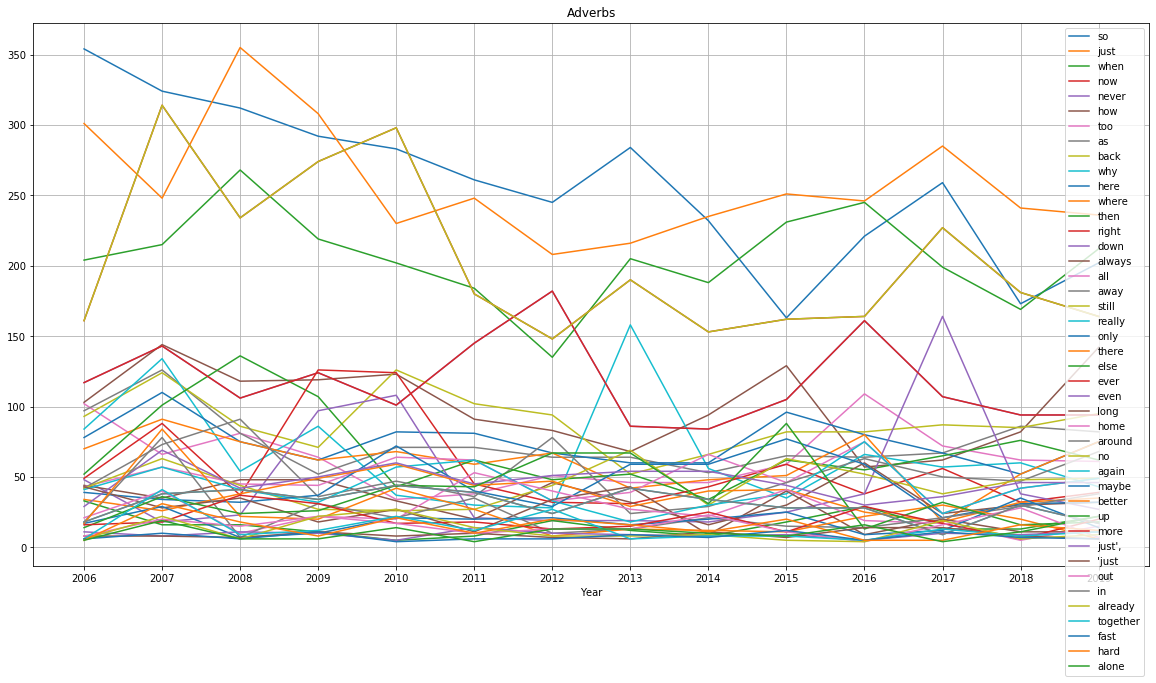

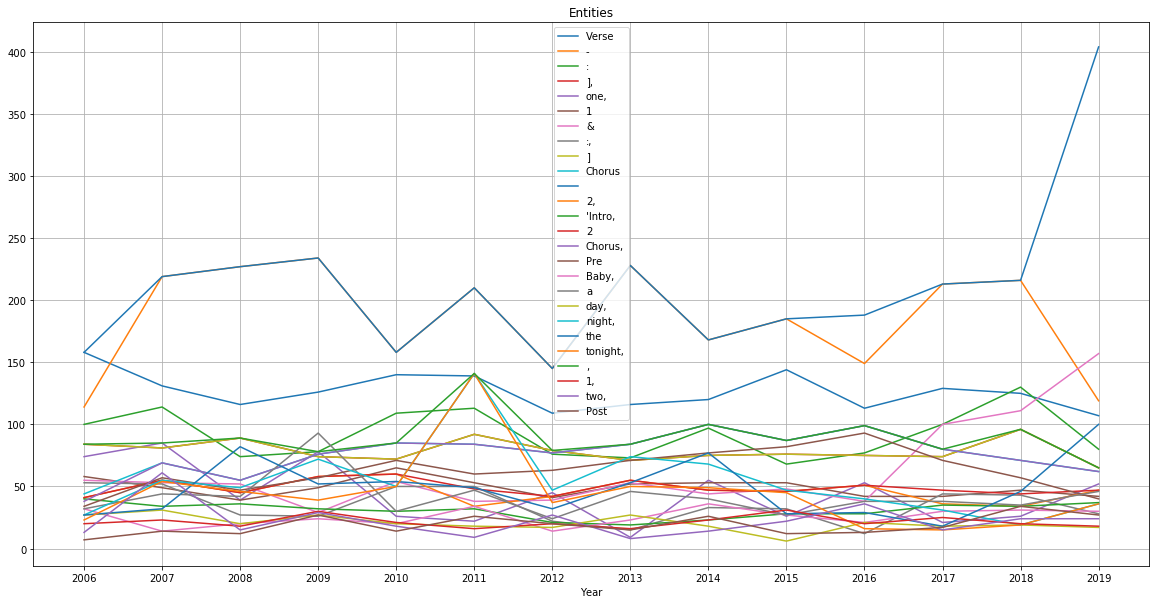

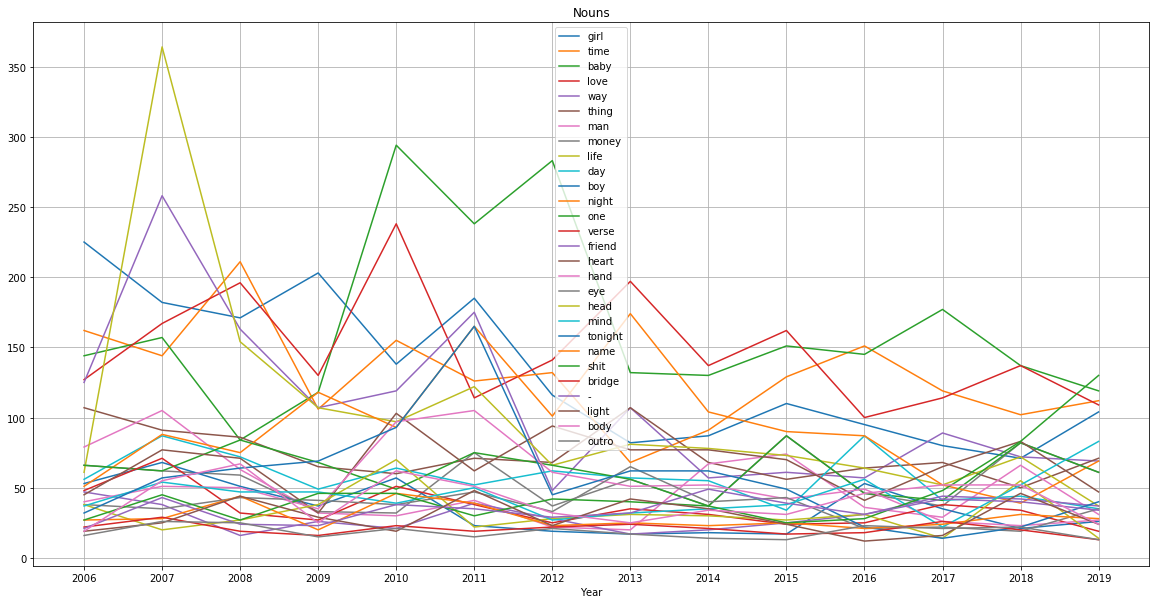

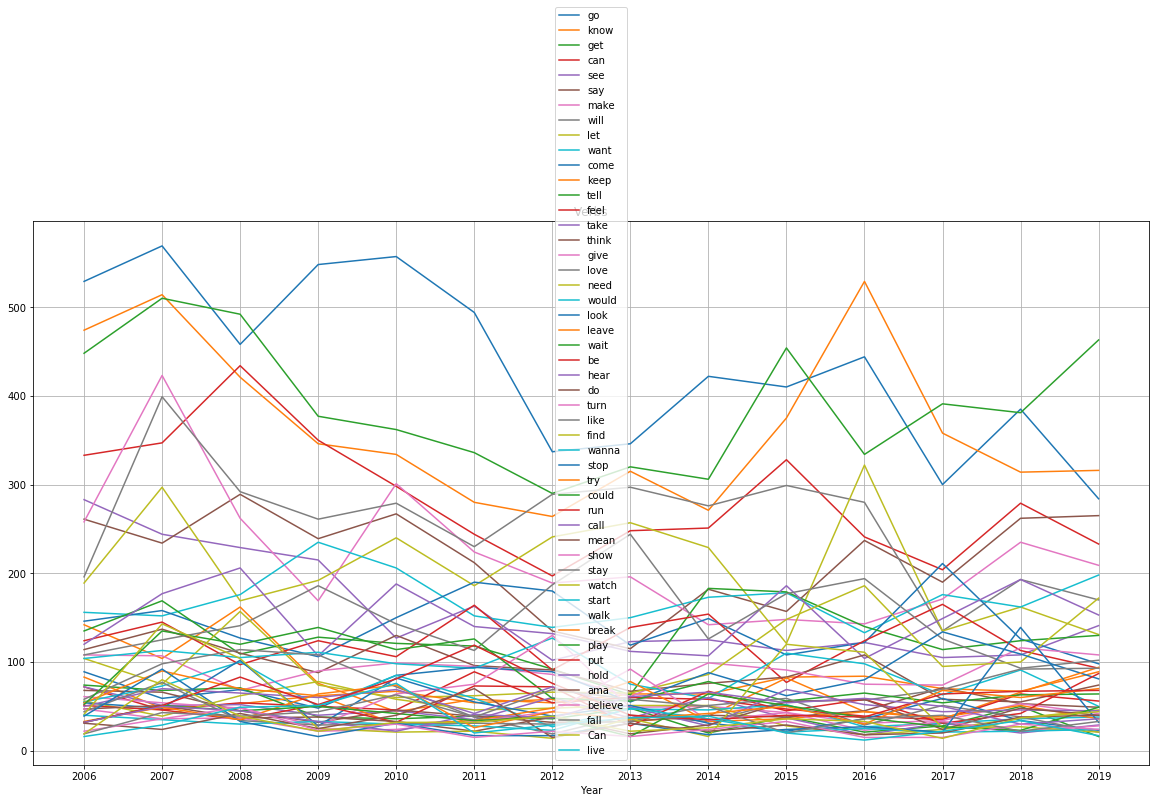

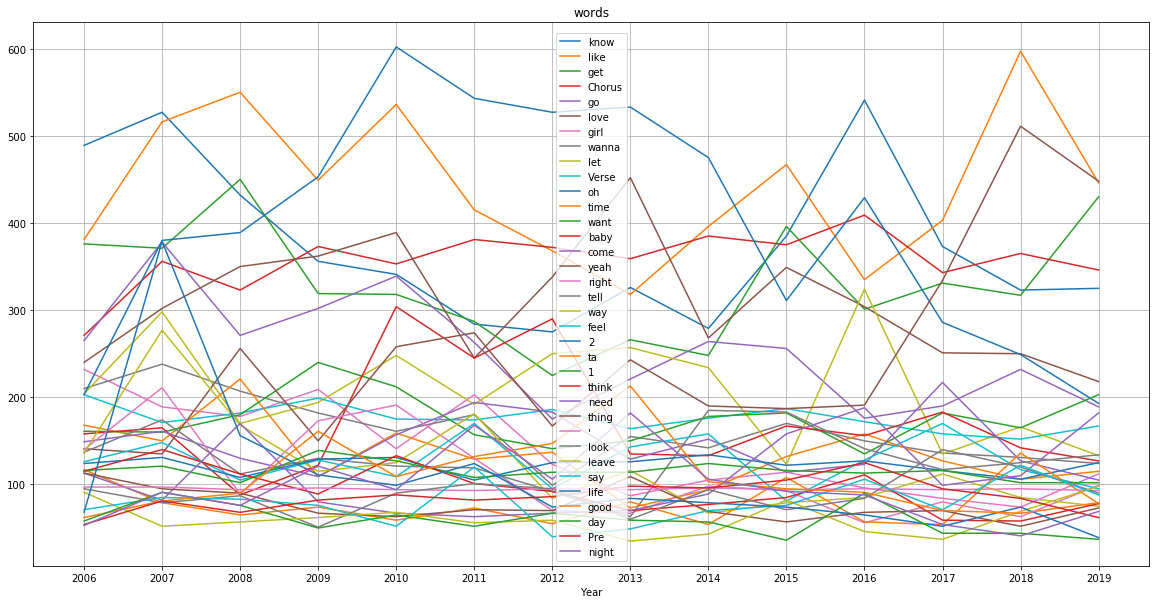

In [150]:
#5. graph popular terms by year.
all_adverbs_by_year.plot(figsize=(20, 10), title="Adverbs", grid="true", xticks=all_adverbs_by_year.index)
all_entities_by_year.plot(figsize=(20, 10), title="Entities", grid="true", xticks=all_entities_by_year.index)
all_nouns_by_year.plot(figsize=(20, 10), title="Nouns", grid="true", xticks=all_nouns_by_year.index)
all_verbs_by_year.plot(figsize=(20, 10), title="Verbs", grid="true", xticks=all_verbs_by_year.index)
all_words_by_year.plot(figsize=(20, 10), title="words", grid="true", xticks=all_words_by_year.index)

In [ ]:
#testing
# ti =5 #3 = humble 5 = bad and boujee
# song = genius_spacy_data.iloc[ti]
# lyrics = song['Lyrics']
# lyrics_contr = expand_contractions(lyrics)
# doc = nlp(lyrics_contr)
# cleaned = remove_adlibs(lyrics_contr)
# print (cleaned)


In [ ]:
#testing
# doc = nlp("i want to get this back as a string")
# print(str(doc))
# assert str(doc) == "i want to get this back as a string"